In [90]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Requires: pip install pykan

import os
import seaborn as sns
import datetime as datetime

In [91]:
import kan


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_kan_feature(model, feature_name, feature_cols, X_train, scaler_X):
    """
    Plots the specific learned function (Physical Law) for a given feature.
    
    Args:
        model: The trained KAN model
        feature_name (str): The exact name of the column to plot (e.g. 'Wind Cooling')
        feature_cols (list): The list of all feature names used in training
        X_train (numpy array): The RAW (unscaled) training data (for calculating means/ranges)
        scaler_X (StandardScaler): The fitted scaler used to transform the data
    """
    
    # 1. Find the index
    try:
        feature_index = feature_cols.index(feature_name)
    except ValueError:
        print(f"❌ ERROR: '{feature_name}' not found in feature list.")
        return

    # 2. Setup Dimensions
    input_dim = X_train.shape[1]
    
    # Get device from model parameters
    device = next(model.parameters()).device
    
    # 3. Create Synthetic Data (Base = Mean of everything)
    # We use 100 points for a smooth curve
    dummy_input_raw = np.zeros((100, input_dim))
    
    for i in range(input_dim):
        # Fill every column with its AVERAGE value from the real world
        # This isolates the feature we care about
        dummy_input_raw[:, i] = np.mean(X_train[:, i])

    # 4. Vary the Target Feature
    min_val = np.min(X_train[:, feature_index])
    max_val = np.max(X_train[:, feature_index])
    seq_values = np.linspace(min_val, max_val, 100)
    
    dummy_input_raw[:, feature_index] = seq_values

    # 5. Scale & Predict
    # The model speaks "Scaled", so we translate our raw numbers
    dummy_input_scaled = scaler_X.transform(dummy_input_raw)
    dummy_tensor = torch.from_numpy(dummy_input_scaled).float().to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(dummy_tensor)
    
    # Flatten for plotting
    preds_flat = predictions.cpu().numpy().flatten()

    # 6. Plot
    plt.figure(figsize=(8, 5))
    plt.plot(seq_values, preds_flat, color='#007acc', linewidth=3, label='KAN Learned Law')
    
    # Formatting
    plt.title(f"Effect of {feature_name}", fontsize=14)
    plt.xlabel(f"{feature_name} (Physical Units)", fontsize=12)
    plt.ylabel("Clearsky Index (Efficiency)", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add Reference Line
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, label="100% Efficiency")
    
    # Add "Slope Arrow" to show direction
    if preds_flat[-1] > preds_flat[0]:
        color = 'green'
        msg = "Positive Impact"
    else:
        color = 'orange'
        msg = "Negative Impact"
        
    dx = max_val - min_val
    dy = preds_flat[-1] - preds_flat[0]
    # Only draw arrow if there is a significant change
    if abs(dy) > 0.05:
        plt.arrow(min_val, preds_flat[0], dx, dy, color=color, alpha=0.5, width=0.005)
        plt.text(min_val, preds_flat[-1], msg, color=color, fontweight='bold')

    plt.legend()
    plt.show()

In [93]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
MODEL_DIR = f'{HOME_DIR}/model/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
TRAIN_DATA_DIR = f'{DATA_DIR}/training_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
BACKUP_FILE_TYPE = 'feather'  # Options: 'csv', 'feather', 'parquet'

# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 12
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


In [94]:
hourly_nighlty_threshold = 50

In [95]:
df_merge_hourly = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_full_data.feather")

# Remove all rows where Clear sky GHI is less than or equal to 50
df_merge_hourly = df_merge_hourly[df_merge_hourly['Clear sky GHI'] > hourly_nighlty_threshold]


In [96]:
level1_features = [level for level in df_merge_hourly.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_merge_hourly.columns.tolist() if level.startswith('level2_')]

In [97]:

display(pd.DataFrame({"Columns": df_merge_hourly.columns, "Data Types": df_merge_hourly.dtypes}))

,Columns,Data Types
index,index,int64
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
...,...,...
Hour,Hour,int32
Clearsky_Index,Clearsky_Index,float64
PV(W)_error,PV(W)_error,float64
PV(W)_error_index,PV(W)_error_index,float64


In [98]:

feature_cols = []
# Columns: ['index', 'DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)', 'WeekOfYear', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
feature_cols = []
test_no="999"
# Define target column

target_col = 'PV(W)'
# Kan Prefers Clearsky_Index
#target_col = 'Clearsky_Index'
#target_col = 'PV(W)_error'
#target_col = 'PV(W)_error_index'
#
test_name=f"Optimal Features  No Level 2 and No Clearsky - Target {target_col}"
notes="This is the best combination of features exclude level 2 and no clearsky weather features"

# Put change here to add more features
feature_cols.append('Temperature(C)')
feature_cols.append('Humidity(%)')
feature_cols.append('Sunshine Duration')
#feature_cols.append('Condition Code')
feature_cols.append('Precipitation(mm)')
feature_cols.append('Dew Point(C)')
feature_cols.append('Wind Direction(deg)')
feature_cols.append('Wind Speed(m/s)')
feature_cols.append('Wind Gust(m/s)')
feature_cols.append('Pressure(hPa)')
#feature_cols.append('Snow Depth(cm)')
feature_cols.append('Wind Cooling')
#  level1_features
#feature_cols.append('# Observation period')
#feature_cols.append('TOA')
#feature_cols.append('Clear sky GHI')
#feature_cols.append('Clear sky BHI')
#feature_cols.append('Clear sky DHI')
#feature_cols.append('Clear sky BNI')
# Relate to target #feature_cols.append('GHI')
# Relate to target #feature_cols.append('BHI')
# Relate to target #feature_cols.append('DHI')
# Relate to target #feature_cols.append('BNI')
# String ignore feature_cols.append('Reliability,')
# Relate to target #feature_cols.append('POA_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POA_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('Power_Pane_I(W)')
# Relate to target #feature_cols.append('Power_Pane_II(W)')
#feature_cols.append('Power_ClearSky_Pane_I(W)')
#feature_cols.append('Power_ClearSky_Pane_II(W)')
# Relate to target #feature_cols.append('Total_Power_Output(W)')
feature_cols.append('Total_Power_ClearSky_Output(W)')
#feature_cols.append('WeekOfYear')
feature_cols.append('Month_Sin')
feature_cols.append('DayOfYear_Sin')
feature_cols.append('HourOfDay_Sin')
feature_cols.append('Month_Cos')
feature_cols.append('DayOfYear_Cos')
feature_cols.append('HourOfDay_Cos')
# Add momentum features
#feature_cols.append('Temp_Momentum')
#feature_cols.append('Humidity_Momentum')
#feature_cols.append('WindSpeed_Momentum')
#feature_cols.append('Total_Power_ClearSky_Output(W)_Momentum')
# Add lag features
feature_cols.append('Temp_Lag1')
feature_cols.append('Humidity_Lag1')
feature_cols.append('WindSpeed_Lag1')
feature_cols.append('Total_Power_ClearSky_Output(W)_Lag1')
#  level2_features
feature_cols += level2_features
#  level1_features
#feature_cols += level1_features

print(f"\nTesting Random Forest Regressor with target: {target_col} and features: {feature_cols}")



Testing Random Forest Regressor with target: PV(W) and features: ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'Month_Cos', 'DayOfYear_Cos', 'HourOfDay_Cos', 'Temp_Lag1', 'Humidity_Lag1', 'WindSpeed_Lag1', 'Total_Power_ClearSky_Output(W)_Lag1', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']


In [99]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [100]:
# ==========================================# 1. Prepare Data# ==========================================# Ensure Total_Power_ClearSky_Output(W) exists for PV(W) conversionif 'Total_Power_ClearSky_Output(W)' not in df_merge_hourly.columns:    raise ValueError("Total_Power_ClearSky_Output(W) column not found - needed for PV(W) metrics")# Drop NaNsmodel_df = df_merge_hourly.dropna(subset=feature_cols + [target_col])# Split Data - preserve dataframe structure for later PV(W) conversiontrain_df, test_df = train_test_split(model_df, test_size=0.2, random_state=42)# Extract features and targetX_train = train_df[feature_cols].valuesy_train = train_df[target_col].values.reshape(-1, 1)X_test = test_df[feature_cols].valuesy_test = test_df[target_col].values.reshape(-1, 1)# Store Total_Power_ClearSky_Output(W) for PV(W) conversionclearsky_train = train_df['Total_Power_ClearSky_Output(W)'].valuesclearsky_test = test_df['Total_Power_ClearSky_Output(W)'].valuesprint(f"Training set: X_train={X_train.shape}, y_train={y_train.shape}")print(f"Test set: X_test={X_test.shape}, y_test={y_test.shape}")# Normalize (Neural Networks LOVES scaled data)scaler_X = StandardScaler()X_train_scaled = scaler_X.fit_transform(X_train)X_test_scaled = scaler_X.transform(X_test)# Create dataset dictionary for pykan# pykan expects keys: 'train_input', 'train_label', 'test_input', 'test_label'dataset = {}dataset['train_input'] = torch.from_numpy(X_train_scaled).float()dataset['train_label'] = torch.from_numpy(y_train).float()dataset['test_input'] = torch.from_numpy(X_test_scaled).float()dataset['test_label'] = torch.from_numpy(y_test).float()print("\nData prepared for KAN model")

In [101]:
input_dim = X_train.shape[1]

In [102]:
# ==========================================
# 2. Define & Train the KAN
# ==========================================

# Initialize KAN
# width: [input_dim, hidden_dim, output_dim]
# grid: granularity of the spline grid (higher = more detailed but prone to overfitting)
# k: order of the spline (k=3 is cubic)
input_dim = X_train.shape[1]
print(f"Input dimension for KAN: {input_dim}")

model = kan.KAN(width=[input_dim,8, 1],
                 grid=18, 
                 k=3, 
                 seed=42)

print("Starting KAN Training (using LBFGS optimizer)...")
print(f"Input dimension: {input_dim}")
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")

# Train the KAN model using the dataset dictionary
print("\nTraining KAN model with LBFGS optimizer...")
results = model.fit(dataset, 
                    opt='LBFGS', 
                    steps=40, 
                    lamb=0.005, 
                    lamb_entropy=0.01)

print("\n✓ KAN Training Complete!")
print(f"Training iterations completed: 50")




Input dimension for KAN: 26
checkpoint directory created: ./model
saving model version 0.0
Starting KAN Training (using LBFGS optimizer)...
Input dimension: 26
Training samples: 3508
Test samples: 878

Training KAN model with LBFGS optimizer...


description:   0%|                                                           | 0/40 [00:00<?, ?it/s]

| train_loss: 2.95e+02 | test_loss: 7.88e+02 | reg: 1.08e+03 | : 100%|█| 40/40 [01:11<00:00,  1.80s/

saving model version 0.1

✓ KAN Training Complete!
Training iterations completed: 50


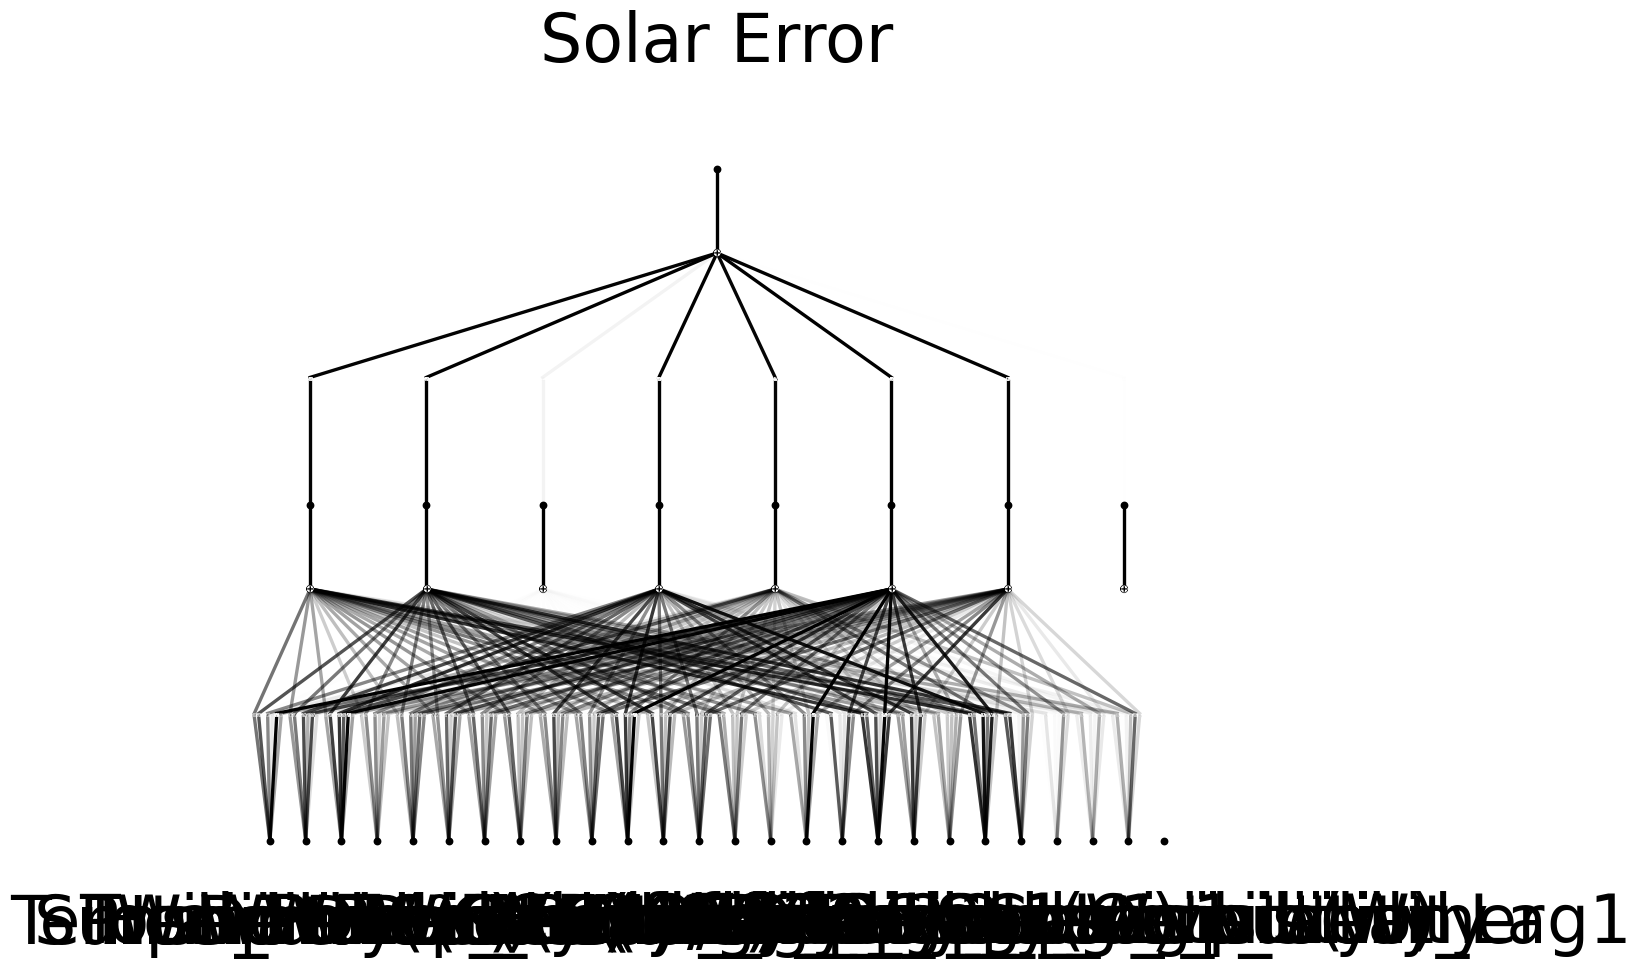

In [103]:
# Visualize the learned functions
# scale=1.0 scales the diagram size
model.plot(beta=10, scale=1.2, in_vars=features, out_vars=['Solar Error'])
plt.show()

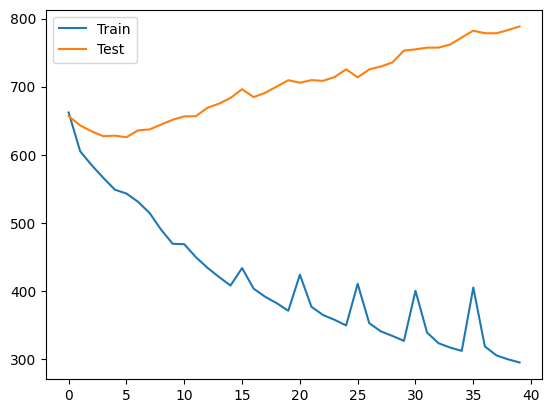

In [104]:
# 3. Check for Convergence
plt.plot(results['train_loss'], label='Train')
plt.plot(results['test_loss'], label='Test')
plt.legend()
plt.show()

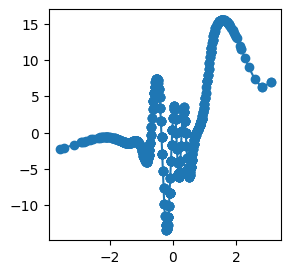

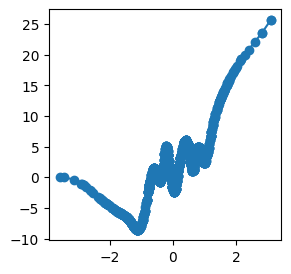

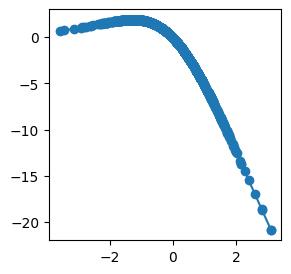

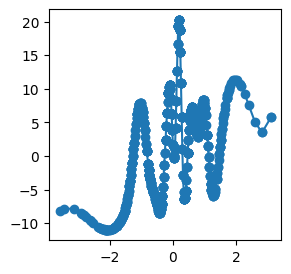

In [105]:
l = 0
i = 0
j = 3
x, y = model.get_fun(l,i,0)
x, y = model.get_fun(l,i,1)
x, y = model.get_fun(l,i,2)
x, y = model.get_fun(l,i,j)

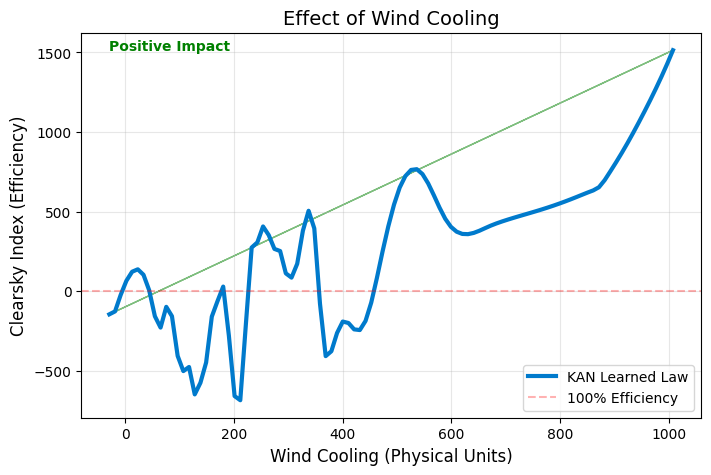

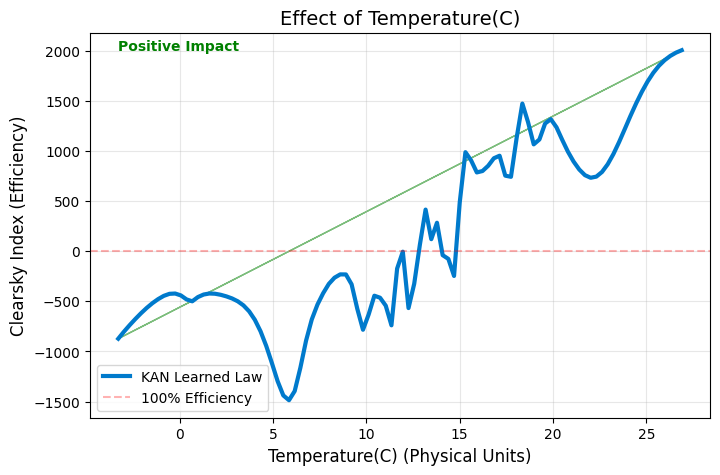

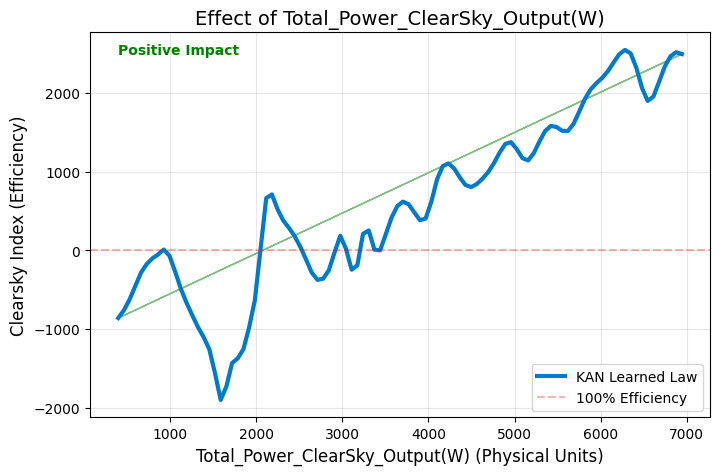

In [106]:
# Check Wind Cooling (Should go UP)
plot_kan_feature(model, "Wind Cooling", feature_cols, X_train, scaler_X)

# Check Temperature (Should go DOWN)
plot_kan_feature(model, "Temperature(C)", feature_cols, X_train, scaler_X)

# Check Sun Position (Should curve)
plot_kan_feature(model, "Total_Power_ClearSky_Output(W)", feature_cols, X_train, scaler_X)

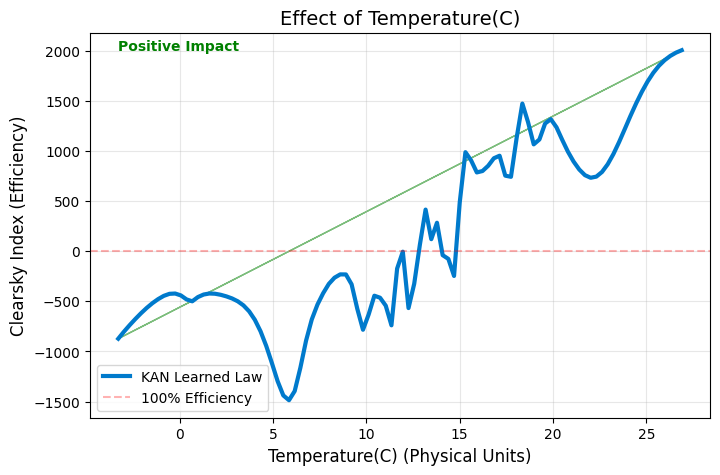

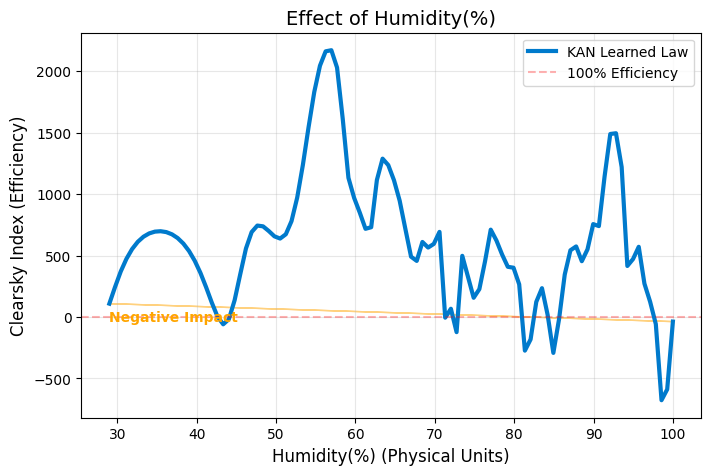

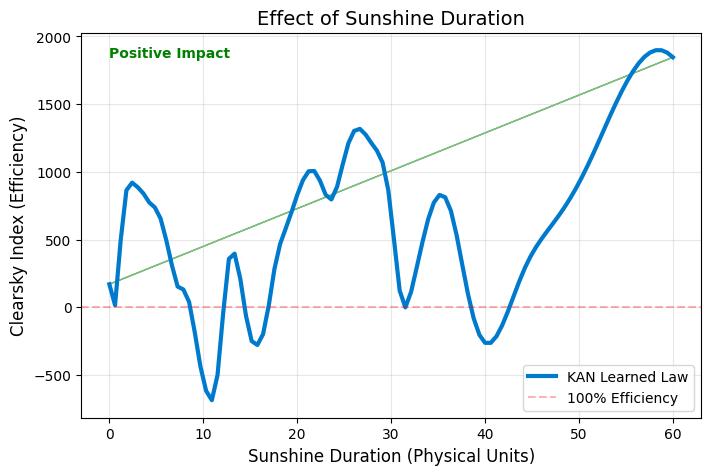

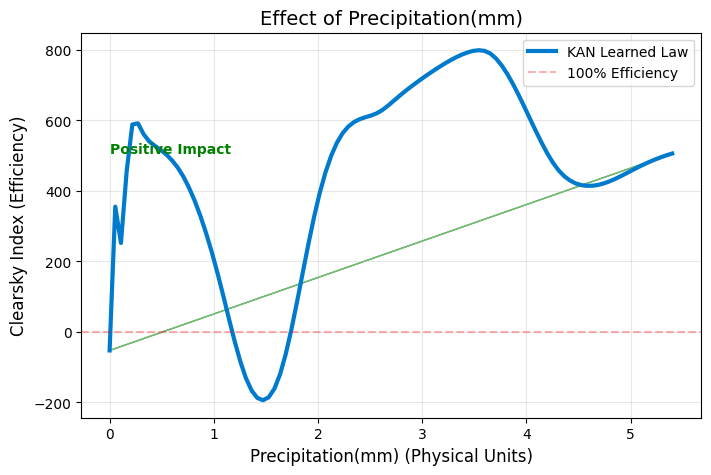

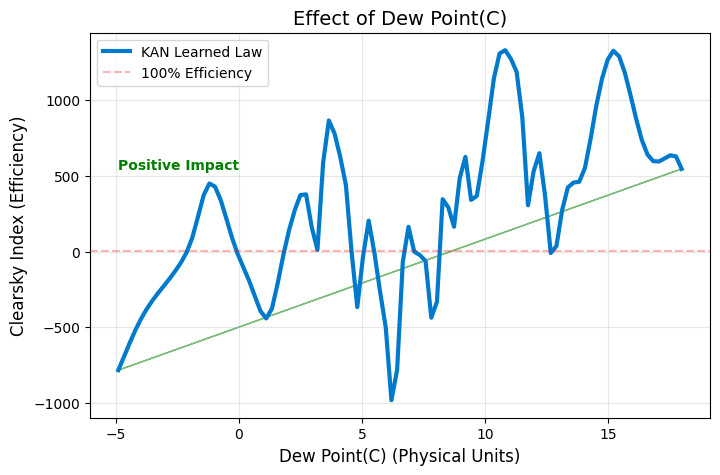

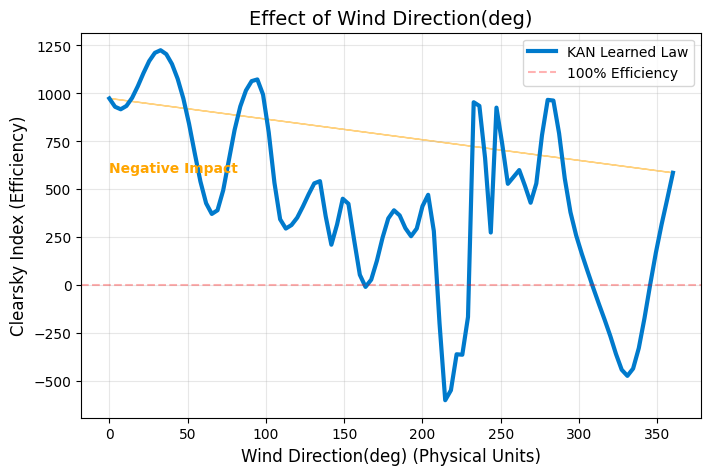

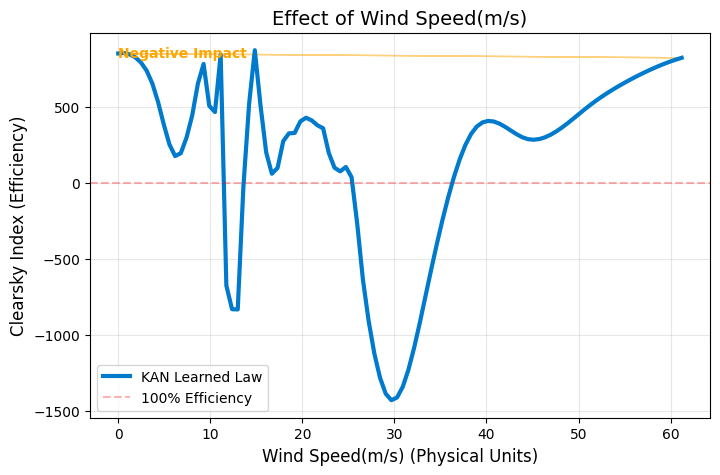

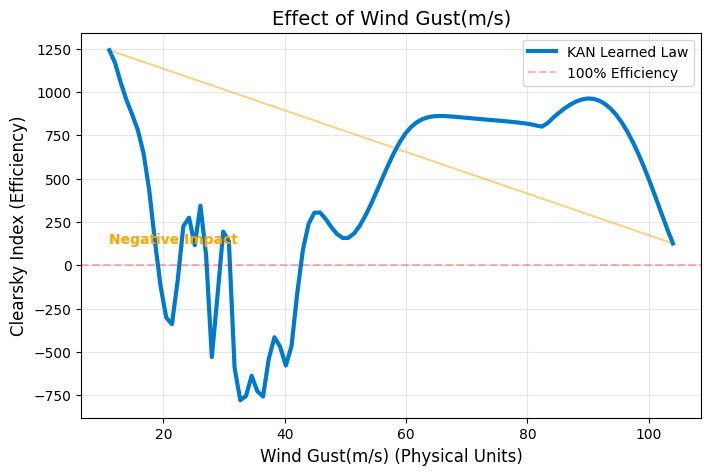

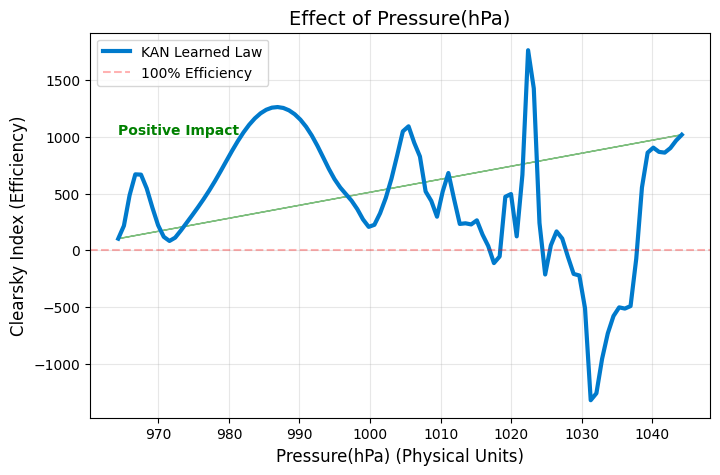

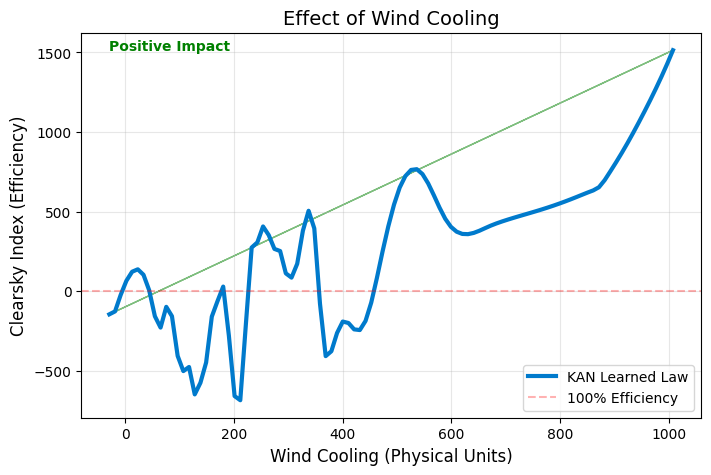

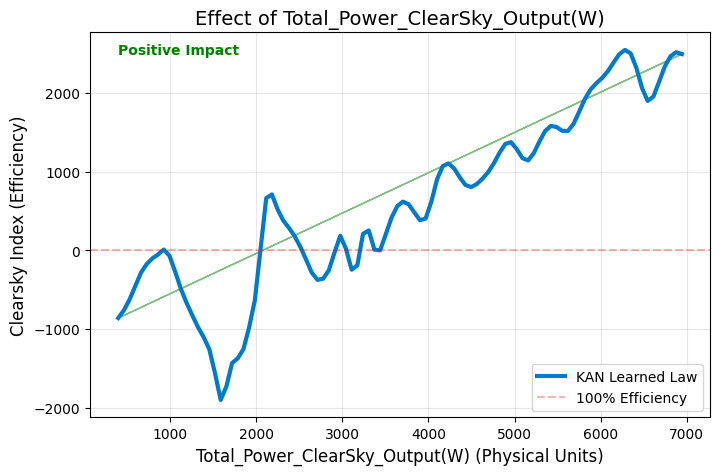

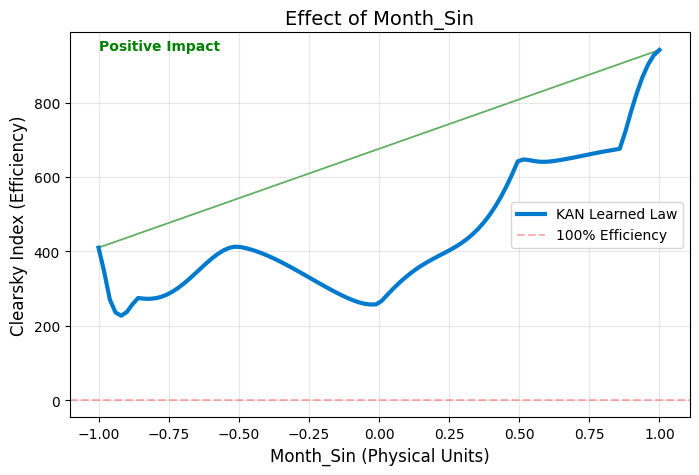

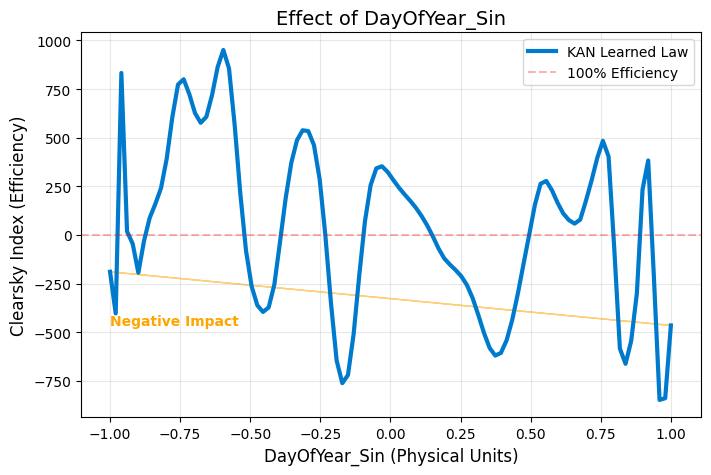

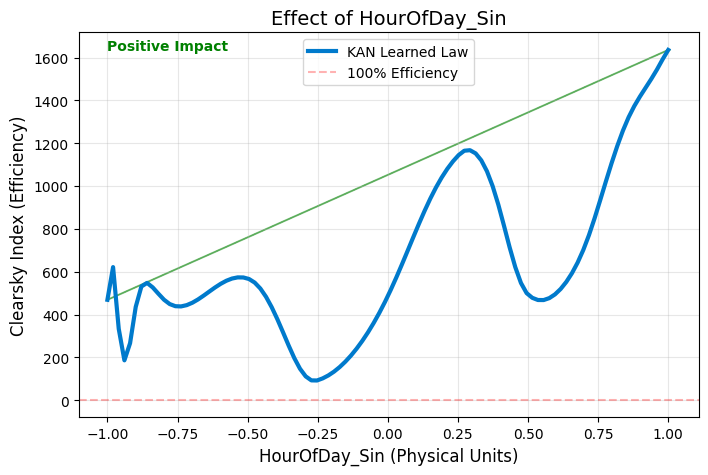

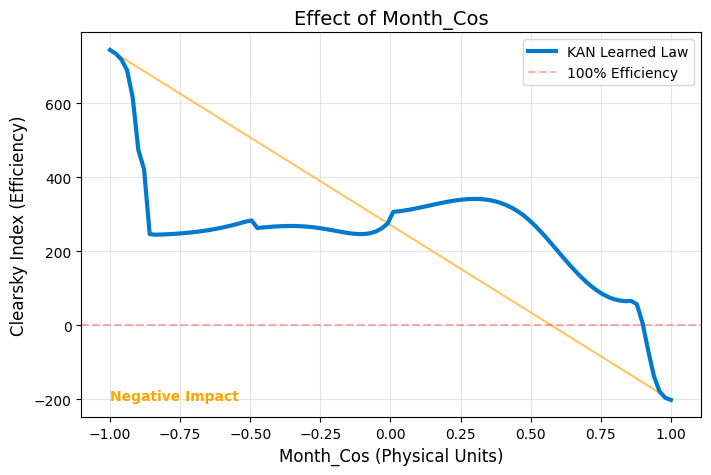

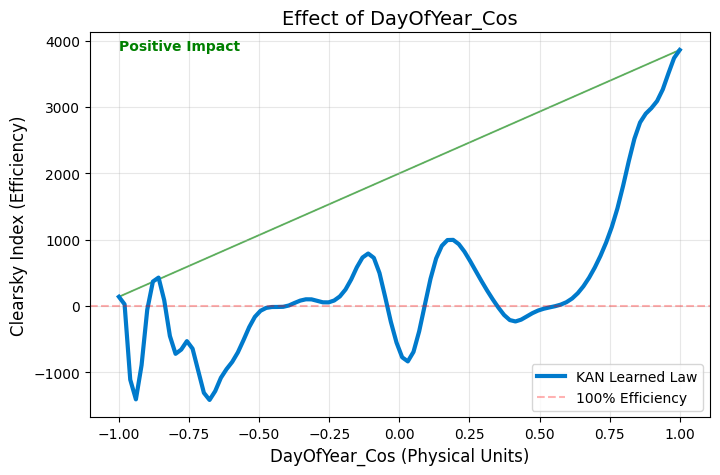

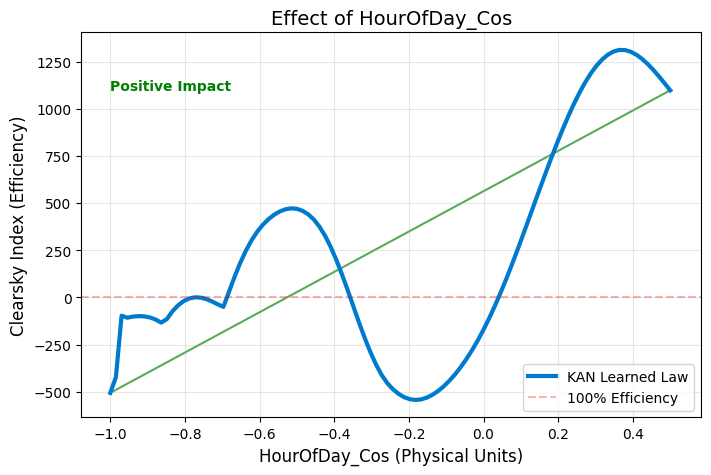

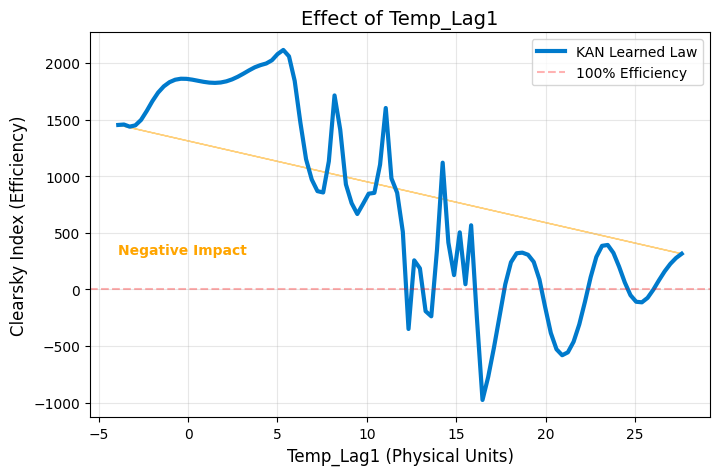

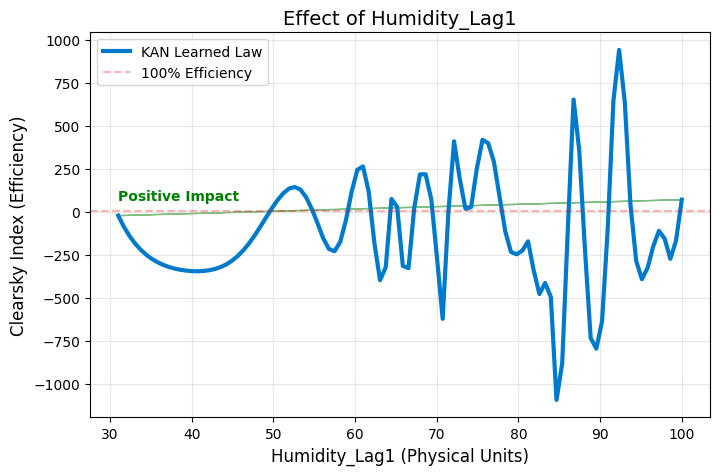

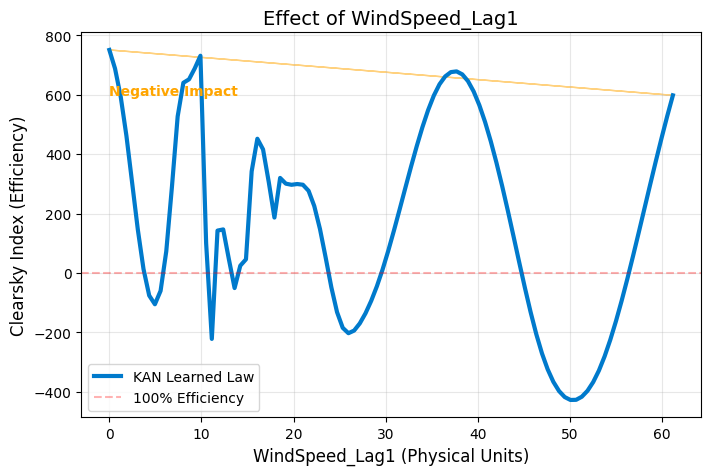

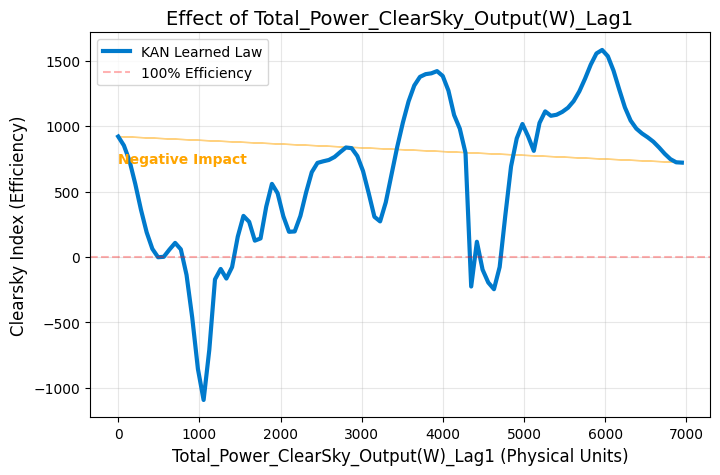

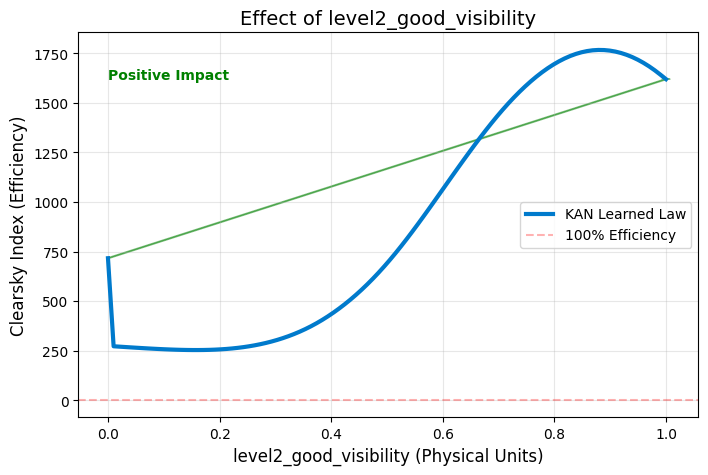

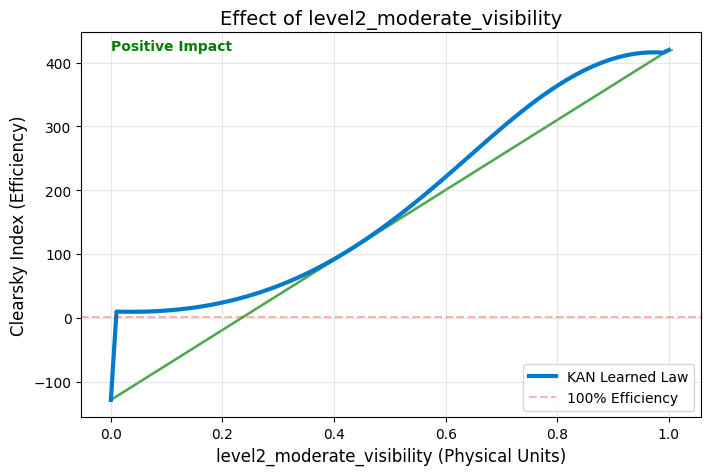

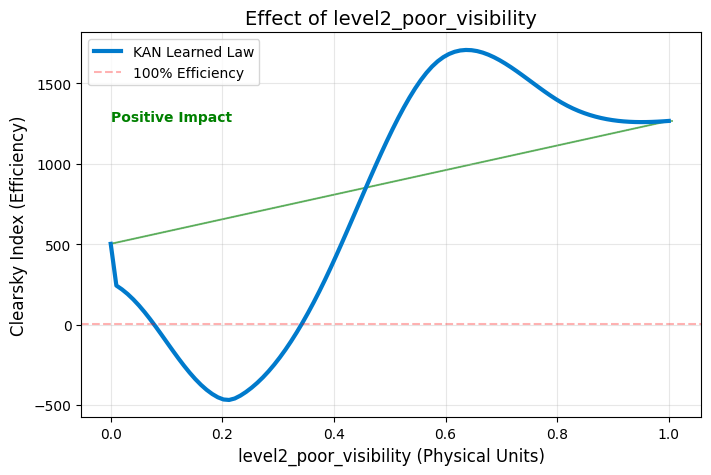

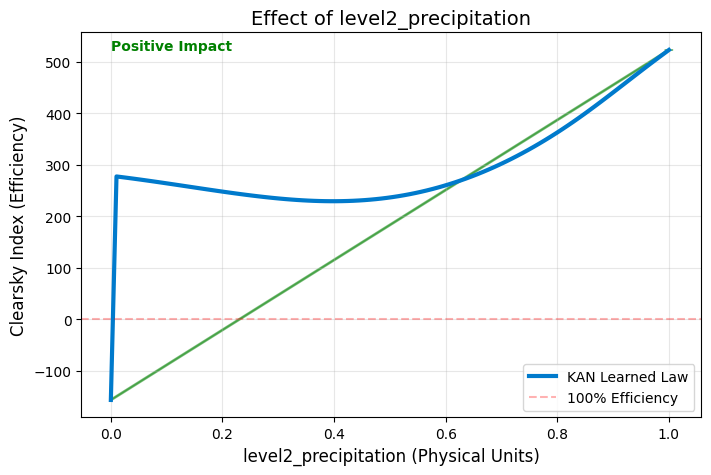

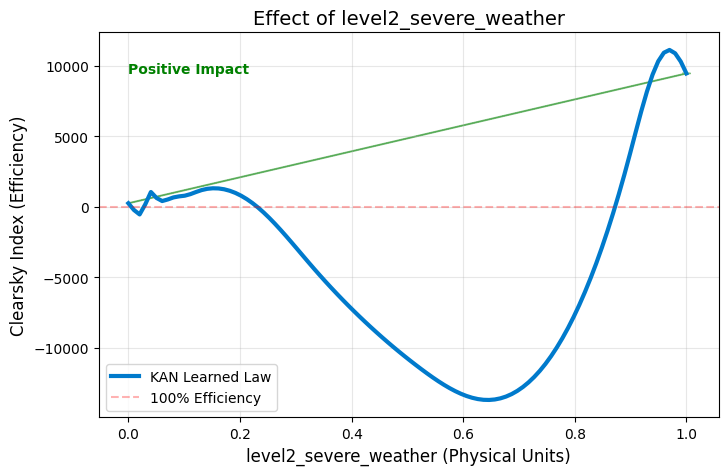

In [107]:
for feature in feature_cols:
    plot_kan_feature(model, feature, feature_cols, X_train, scaler_X)

In [108]:
import numpy as npfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score# =========================================================# Get Predictions from the Model# =========================================================# Get predictions on test and train setsmodel.eval()with torch.no_grad():    y_test_pred_tensor = model(dataset['test_input'])    y_train_pred_tensor = model(dataset['train_input'])y_pred = y_test_pred_tensor.numpy()y_train_pred = y_train_pred_tensor.numpy()# Get actual valuesy_test_actual = y_testy_train_actual = y_train# Convert to PV(W) based on target_colprint(f"\nConverting predictions to PV(W) for target: {target_col}")if target_col == 'PV(W)':    y_test_pvw = y_test_actual    y_test_pvw_pred = y_pred    y_train_pvw = y_train_actual    y_train_pvw_pred = y_train_predelif target_col == 'Clearsky_Index':    y_test_pvw = y_test_actual * clearsky_test.reshape(-1, 1)    y_test_pvw_pred = y_pred * clearsky_test.reshape(-1, 1)    y_train_pvw = y_train_actual * clearsky_train.reshape(-1, 1)    y_train_pvw_pred = y_train_pred * clearsky_train.reshape(-1, 1)elif target_col == 'PV(W)_error':    y_test_pvw = y_test_actual + clearsky_test.reshape(-1, 1)    y_test_pvw_pred = y_pred + clearsky_test.reshape(-1, 1)    y_train_pvw = y_train_actual + clearsky_train.reshape(-1, 1)    y_train_pvw_pred = y_train_pred + clearsky_train.reshape(-1, 1)    # Clip to non-negative    y_test_pvw = np.clip(y_test_pvw, 0, None)    y_test_pvw_pred = np.clip(y_test_pvw_pred, 0, None)    y_train_pvw = np.clip(y_train_pvw, 0, None)    y_train_pvw_pred = np.clip(y_train_pvw_pred, 0, None)elif target_col == 'PV(W)_error_index':    y_test_pvw = (y_test_actual * clearsky_test.reshape(-1, 1)) + clearsky_test.reshape(-1, 1)    y_test_pvw_pred = (y_pred * clearsky_test.reshape(-1, 1)) + clearsky_test.reshape(-1, 1)    y_train_pvw = (y_train_actual * clearsky_train.reshape(-1, 1)) + clearsky_train.reshape(-1, 1)    y_train_pvw_pred = (y_train_pred * clearsky_train.reshape(-1, 1)) + clearsky_train.reshape(-1, 1)    # Clip to non-negative    y_test_pvw = np.clip(y_test_pvw, 0, None)    y_test_pvw_pred = np.clip(y_test_pvw_pred, 0, None)    y_train_pvw = np.clip(y_train_pvw, 0, None)    y_train_pvw_pred = np.clip(y_train_pvw_pred, 0, None)else:    print(f"Warning: Unknown target_col '{target_col}', using direct values as PV(W)")    y_test_pvw = y_test_actual    y_test_pvw_pred = y_pred    y_train_pvw = y_train_actual    y_train_pvw_pred = y_train_pred# Apply physics constraints to predictionsy_pred = np.clip(y_pred, 0, None)y_train_pred = np.clip(y_train_pred, 0, None)# =========================================================# Calculate Metrics# =========================================================def calculate_metrics(y_true, y_pred):    rmse = np.sqrt(mean_squared_error(y_true, y_pred))    mae = mean_absolute_error(y_true, y_pred)    r2 = r2_score(y_true, y_pred)    # Normalized based on range (max - min) - standard practice for solar prediction    normalization_factor = np.max(y_true) - np.min(y_true)    n_rmse = rmse / normalization_factor if normalization_factor > 0 else 0    n_mae = mae / normalization_factor if normalization_factor > 0 else 0    # Calculate accuracy as 1 - (mae / mean of y_true)    accuracy_score = 1 - (mae / np.mean(y_true)) if np.mean(y_true) > 0 else 0    return rmse, mae, r2, n_rmse, n_mae, accuracy_score# Calculate metrics for target columntest_rmse, test_mae, test_r2, test_n_rmse, test_n_mae, test_accuracy = calculate_metrics(y_test_actual, y_pred)train_rmse, train_mae, train_r2, train_n_rmse, train_n_mae, train_accuracy = calculate_metrics(y_train_actual, y_train_pred)# Calculate metrics for PV(W)test_rmse_pvw, test_mae_pvw, test_r2_pvw, test_n_rmse_pvw, test_n_mae_pvw, test_accuracy_pvw = calculate_metrics(y_test_pvw, y_test_pvw_pred)train_rmse_pvw, train_mae_pvw, train_r2_pvw, train_n_rmse_pvw, train_n_mae_pvw, train_accuracy_pvw = calculate_metrics(y_train_pvw, y_train_pvw_pred)print("="*50)print(f"Model Performance Metrics - {target_col}")print("="*50)print(f"{'Metric':<15} {'Train':<15} {'Test':<15}")print(f"{'-'*50}")print(f"{'RMSE:':<15} {train_rmse:>10.2f}     {test_rmse:>10.2f}")print(f"{'MAE:':<15} {train_mae:>10.2f}     {test_mae:>10.2f}")print(f"{'R²:':<15} {train_r2:>10.4f}     {test_r2:>10.4f}")print(f"{'N-RMSE:':<15} {train_n_rmse:>10.4f}     {test_n_rmse:>10.4f}")print(f"{'N-MAE:':<15} {train_n_mae:>10.4f}     {test_n_mae:>10.4f}")print(f"{'N-RMSE %:':<15} {train_n_rmse*100:>10.2f}     {test_n_rmse*100:>10.2f}")print(f"{'N-MAE %:':<15} {train_n_mae*100:>10.2f}     {test_n_mae*100:>10.2f}")print(f"{'Accuracy:':<15} {train_accuracy:>10.4f}     {test_accuracy:>10.4f}")print("="*50)print("\n" + "="*50)print(f"Model Performance Metrics - PV(W)")print("="*50)print(f"{'Metric':<15} {'Train':<15} {'Test':<15}")print(f"{'-'*50}")print(f"{'RMSE:':<15} {train_rmse_pvw:>10.2f}     {test_rmse_pvw:>10.2f}")print(f"{'MAE:':<15} {train_mae_pvw:>10.2f}     {test_mae_pvw:>10.2f}")print(f"{'R²:':<15} {train_r2_pvw:>10.4f}     {test_r2_pvw:>10.4f}")print(f"{'N-RMSE:':<15} {train_n_rmse_pvw:>10.4f}     {test_n_rmse_pvw:>10.4f}")print(f"{'N-MAE:':<15} {train_n_mae_pvw:>10.4f}     {test_n_mae_pvw:>10.4f}")print(f"{'N-RMSE %:':<15} {train_n_rmse_pvw*100:>10.2f}     {test_n_rmse_pvw*100:>10.2f}")print(f"{'N-MAE %:':<15} {train_n_mae_pvw*100:>10.2f}     {test_n_mae_pvw*100:>10.2f}")print(f"{'Accuracy:':<15} {train_accuracy_pvw:>10.4f}     {test_accuracy_pvw:>10.4f}")print("="*50)

MAE:  587.87 W
RMSE: 773.63 W
R²:   0.6899
N-MAE: 10.45%
N-RMSE: 13.75%


In [ ]:
# Export metrics to CSV
import os

# Define test parameters (customize as needed)
test_no = '001'
test_name = 'KAN Model'
notes = 'Kolmogorov-Arnold Network model'

# Create results directory if it doesn't exist
os.makedirs('results', exist_ok=True)

csv_file = 'results/kan_test_metrics.csv'

# Write to CSV
with open(csv_file, 'a') as f:
    # If file is empty, write header
    if os.path.getsize(csv_file) == 0 if os.path.exists(csv_file) else True:
        header = ['Model', 'Test No', 'Test Name', 'Target Column',
                  'Test RMSE', 'Test MAE', 'Test R2', 'Test N-RMSE', 'Test N-MAE','Test N-RMSE %', 'Test N-MAE %', 'Test Accuracy',
                  'Train RMSE', 'Train MAE', 'Train R2', 'Train N-RMSE', 'Train N-MAE', 'Train N-RMSE %', 'Train N-MAE %', 'Train Accuracy',
                  'Test PV(W) RMSE', 'Test PV(W) MAE', 'Test PV(W) R2', 'Test PV(W) N-RMSE', 'Test PV(W) N-MAE','Test PV(W) N-RMSE %', 'Test PV(W) N-MAE %', 'Test PV(W) Accuracy',
                  'Train PV(W) RMSE', 'Train PV(W) MAE', 'Train PV(W) R2', 'Train PV(W) N-RMSE', 'Train PV(W) N-MAE', 'Train PV(W) N-RMSE %', 'Train PV(W) N-MAE %', 'Train PV(W) Accuracy',
                  'Notes', 'Feature Columns']
        f.write(','.join(header) + '\n')
    
    line = []
    line.append('KAN')
    line.append(test_no)
    line.append(test_name)
    line.append(f"{target_col}")
    line.append(f"{test_rmse:.2f}")
    line.append(f"{test_mae:.2f}")
    line.append(f"{test_r2:.4f}")
    line.append(f"{test_n_rmse:.4f}")
    line.append(f"{test_n_mae:.4f}")
    line.append(f"{test_n_rmse*100:.4f}")
    line.append(f"{test_n_mae*100:.4f}")
    line.append(f"{test_accuracy:.4f}")
    line.append(f"{train_rmse:.2f}")
    line.append(f"{train_mae:.2f}")
    line.append(f"{train_r2:.4f}")
    line.append(f"{train_n_rmse:.4f}")
    line.append(f"{train_n_mae:.4f}")
    line.append(f"{train_n_rmse*100:.4f}")
    line.append(f"{train_n_mae*100:.4f}")
    line.append(f"{train_accuracy:.4f}")
    line.append(f"{test_rmse_pvw:.2f}")
    line.append(f"{test_mae_pvw:.2f}")
    line.append(f"{test_r2_pvw:.4f}")
    line.append(f"{test_n_rmse_pvw:.4f}")
    line.append(f"{test_n_mae_pvw:.4f}")
    line.append(f"{test_n_rmse_pvw*100:.4f}")
    line.append(f"{test_n_mae_pvw*100:.4f}")
    line.append(f"{test_accuracy_pvw:.4f}")
    line.append(f"{train_rmse_pvw:.2f}")
    line.append(f"{train_mae_pvw:.2f}")
    line.append(f"{train_r2_pvw:.4f}")
    line.append(f"{train_n_rmse_pvw:.4f}")
    line.append(f"{train_n_mae_pvw:.4f}")
    line.append(f"{train_n_rmse_pvw*100:.4f}")
    line.append(f"{train_n_mae_pvw*100:.4f}")
    line.append(f"{train_accuracy_pvw:.4f}")
    line.append(f"{notes if 'notes' in locals() else ''}")
    line.append(f"feature_cols: {':'.join(feature_cols)}")
    f.write(','.join(line) + '\n')

print(f"\nMetrics exported to {csv_file}")


__Save Model__

In [109]:
model.saveckpt(f"{MODEL_DIR}/kan_model_target.ckpt")